# Inspecting dev.to tags and popular articles

More info on the repository README: https://github.com/derlin/dev.to-is-for-web-devs-and-beginners

### **⮕⮕⮕  READ THE ARTICLE ON DEV.TO:**  [**dev.to is for webdevs and beginners - I have data to prove it**](https://dev.to/derlin/devto-is-for-webdevs-and-beginners-i-have-data-to-prove-it-54c4) 

# Foreword
I am on dev.to for a while now, and looking at the featured articles, I keep wondering: is this platform only for web developers and beginners ? I mean, most of the articles that trigger comments and reactions are about javascript, react, css or beginners, newbie, etc. 

I have a few articles, that I consider not that bad (not that great either), but they don't seem to take. Might it be because I am not writing about stuff that the community cares about ?

Instead of staying in the dark, I tried to better understand what works and doesn't work on dev.to. Here are the results of my peregrinations.

# Getting the data

[dev.to](https://dev.to) is based on forem, which has an API available: https://developers.forem.com/api/v0. Note though that some of the information is incorrect, or at least doesn't work as expected when tried against https://dev.to/api.

The data that I wanted were about tags and articles. More precisely:

* metadata about the most liked articles of all time,
* metadata about the most active tags:
  - the total number of articles for each,
  - the top articles for each.

### Top tags

To get the top tags, I can use the endpoint `https://dev.to/api/tags` (described in the [forem docs](https://developers.forem.com/api/v0#tag/tags/operation/getTags) as returning tags ordered by popularity), along with a `per_page` parameter:
```
https://dev.to/api/tags?per_page=100&page=0
```

I can also fetch the https://dev.to/tags page, and extract the `tag-card` elements.

The problem is, they are not giving the same results... Using the api to fetch the first 100 tags, I got 4 tags that are now *404 Not Found*: `macosapps`, `southafricanews` `sportnews`, `latestnigerianewslat`. This led me to decide to use the https://dev.to/tags page.

### Number of articles per tag

For the number of articles published with a specific tag, there are two numbers:

1. the one shown in the https://dev.to/tags, and 
2. the one shown on the individual tag page, i.e. `https://dev.to/t/<TAG>`

The problem is, they don't match at all ! (1) being often way higher than (2). For example, at the time of writing, the `archlinux` tag shows "*34635 posts published*" on the tags page, but "*151 Posts Published*" on the https://dev.to/t/archlinux page... To settle this, I scrolled until there was no more new fetch, and got 181 articles.

This led me to decide to use the individual tag pages (2) for results.

See the [difference](difference.html) notebook for more info.

### Top articles

To get the top articles, I had to look into the developer console to figure out how dev.to did it. Here is the query url (cleaned a bit to remove unused query parameters):
```
https://dev.to/search/feed_content?class_name=Article&sort_by=public_reactions_count&sort_direction=desc
```
The latter returns the top articles of all time. To get the top articles by tag, I can add the query parameter `tag_names[]=tag1, tag2, ...` (note the space). The actual dev.to site also passes a `tag` parameter, but it doesn't seem to be used. 

The `search` endpoint has a limit on the number of results returned: max 100. To get more, I need to use the `page` and `per_page` query parameters to loop through the paged results.

### Code

This is the theory. In practice, I put up a small python script to do my bidding, see [fetch/devto.py](https://github.com/derlin/dev.to-is-for-web-devs-and-beginners/blob/main/fetch/devto.py).

# Imports

In [1]:
import json

import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

import itertools

pio.templates.default = 'plotly_white'
pio.renderers.default = 'notebook'

-----

# Tags

First, let's load our data into a dataframe. The `top_articles_by_tag.json` has the following structure:
```json
[
 {
  "tag": {
    "name": "...",
    "num_articles": N  // (1) count from the https://dev.to/tags page
  },
  "top_articles": [
    {
      "id": 468082,
      "title": "...",
      "comments_count": 112,
      "public_reactions_count": 10893,
      "reading_time": 5,
      "tag_list": [...],
      // ... and much more
    },
   "total": N         // (2) count from the https://dev.to/t/<TAG> page
 }
]
```

In [2]:
with open('../top_articles_by_tag.json') as f:
    tags_data = json.load(f)

def sum_article_prop(entry, prop):
    return sum(article[prop] for article in entry['top_articles'])

tags = pd.DataFrame([
        [
            entry['tag']['name'], 
            entry['total'], 
            sum_article_prop(entry, 'public_reactions_count'),
            sum_article_prop(entry, 'comments_count')
        ] for entry in tags_data
    ],
    columns=['tag', 'count', 'reactions', 'comments'])

tags = tags.sort_values('count', ascending=False).reset_index()

Let's display the total number of articles per tag (*count*), and the number of *comments* and *reactions* on the first 100 articles for each.

**IMPORTANT**: remember that one article can have up to 4 tags, so a very liked article may boost the scores of multiple tags ! 

In [3]:
fig = go.Figure()

for column in ['count', 'reactions', 'comments']:
    print(f'Total {column}: {tags[column].sum():,}')
    fig.add_trace(go.Scatter(x=tags.tag, y=tags[column], mode='lines+markers', name=column))

fig.update_layout(
    title='Top tags', 
    xaxis=dict(title='tag', tickmode='linear'),
    margin=dict(l=0, r=0, t=30, b=0),
    legend=dict(orientation='h', yanchor='auto', y=1.0, xanchor='auto', x=.5)
)
fig.show()
fig.write_html("plot_tags.html")

Total count: 621,345
Total reactions: 4,211,041
Total comments: 211,510


Let's plot exactly the same data, but with normalized Y-axis. That is, the Y-axis shows the percentage of count/reactions/comments the tag represents.

In [4]:
fig = go.Figure()

for column in ['count', 'reactions', 'comments']:
    fig.add_trace(go.Scatter(x=tags.tag, y=tags[column] / tags[column].sum() * 100, mode='lines+markers', name=column))

fig.update_layout(
    title='Top tags - normalized',
    xaxis=dict(title='tag', tickmode='linear'),
    yaxis=dict(title='%', ticklabelposition='inside'),
    margin=dict(l=0, r=0, t=30, b=0),
    legend=dict(orientation='h', yanchor='auto', y=1.0, xanchor='auto', x=.5)
)
fig.show()

fig.write_html("plot_tags_normalized.html")


Looking at the **number of articles** (*count*) we can see an exponential curve here. `javascript`, `webdev` and `beginners` are really dominating the scene.

The last two "top tags" according to dev.to have only 244 and 151 articles respectively, letting me think that either their calculation has some bugs, or that there is a limited number of trendy tags.

In [5]:
def pp(condition):
    return '\n    ' + ', '.join(tags[condition].tag.tolist())

bold = '\033[1m'
reset = '\x1b[0m'

for high, low in itertools.pairwise([70, 30, 20, 10, 5, 2, 1, 0]):
    print(f'Between {bold}{low}K-{high}K{reset} articles:')
    condition = tags['count'].between(low * 1000, high * 1000)
    print('   ' + ', '.join(tags[condition].tag.tolist()))
    print()

Between 30K-70K articles:
   javascript, webdev, beginners

Between 20K-30K articles:
   tutorial, react, programming

Between 10K-20K articles:
   python, discuss, productivity, css, career, node, devops, codenewbie

Between 5K-10K articles:
   html, opensource, typescript, aws, showdev, github, java, testing, docker, php, security, linux, vue, ruby, git

Between 2K-5K articles:
   angular, go, database, dotnet, csharp, serverless, machinelearning, kubernetes, rails, computerscience, cloud, android, design, laravel, azure, api, algorithms, architecture, help, learning, datascience, vscode, reactnative, graphql, frontend, nextjs, flutter, watercooler, django, ios, codepen, sql, rust, todayilearned, blockchain, performance

Between 1K-2K articles:
   hacktoberfest, startup, kotlin, motivation, news, coding, challenge, mongodb, development, microservices, tailwindcss, postgres, cpp, npm, ux, gamedev, wordpress, writing, devjournal, mobile, dart, leetcode, ai, agile, firebase, management,

The **comments** and **reactions** do not fit exactly the number of articles. Remember, however, that _**we are just looking at the top 100 articles for each tag**_, so it may not be representative.

To see more clearly, let's show the rank in each category. In the latter table, the tags are ranked on count, reactions and comment, and the `∂X` columns are the difference between the rank in *count* (number of articles) and the rank in reactions (`∂r`) or comments (`∂c`). In other words, `∂r=-2` means the tag is 2 ranks lower in reactions than in count. It helps seeing better the peaks and drops from the plot above.

In [6]:
df = tags[['tag']].copy()

for column in ['count', 'reactions', 'comments']:
    df[column] = ((df.shape[0]+1) - tags[column].rank()).astype('int32')

df['∂r'] = df['count'] - df.reactions
df['∂c'] = df['count'] - df.comments

df.style\
    .hide(axis='index')\
    .background_gradient(subset='∂r', cmap='seismic_r', vmin=-abs(df['∂r'].max()), vmax=abs(df['∂r'].max()))\
    .background_gradient(subset='∂c', cmap='seismic_r', vmin=-abs(df['∂c'].max()), vmax=abs(df['∂c'].max()))


From the reactions point of view:
* some types of tags clearly generate "reaction peaks":
   - web-related tags such as: `react`, `css`, `html`, `vscode`, `vue`, `frontend`...
   - generic tags such as: `productivity`, `career`, `computerscience`, `design`, `architecture`, `learning`, `motivation` ...
   - `github`, `git`, and `docker`, which are basic tools any (web) developer should know

* on the other hand, some groups of tags show "reaction drops":
   - languages/framework NOT web-related: `php`, `ruby`, `android`, `laravel`, `kotlin`
   - devops: `devops`, `cloud`, `aws`, `azure`
   - `datascience` and `testing` (← this one was unexpected)

From the comments point of view:
* some obvious tags have a high peak: `discuss`, `watercooler`, `meta`, `writing`, `help`, `showdev`. I am not surprised to also see peaks for tags like `career`, `productivity` or `hacktoberfest`,
* `vscode` has a huge comment bump, I guess because it is the editor of choice for web developers (and IDEs are sacred),
* `linux` and `opensource` generate many comments, which was unexpected,
* as expected, tags for languages/framework NOT web-related or devops have clear comment drops: `python`, `devops`, `aws`, `testing`, `machinelearning`, `kubernetes`, `aws`, `datascience`, ...

--------

# Top Articles

As it is quite difficult to interpret the results based on the top tags, let's look instead at the top 10,000 articles of all time.

In [7]:
with open('../top_articles.json') as f:
    articles_data = json.load(f)

articles = pd.DataFrame(
[
    [
         sorted(article.get('tag_list', [])),
         article['id'], 
         article['title'], 
         article['published_at_int'], 
         article['public_reactions_count'],
         article['comments_count'],
         article['reading_time']
    ] for article in articles_data
], columns=['tags','id','title','date','reactions', 'comments', 'readtime'])

articles.describe()

id          date     reactions     comments      readtime
count  1.000000e+04  1.000000e+04  10000.000000  10000.00000  10000.000000
mean   4.515240e+05  1.593509e+09    328.960900     22.65850      5.981400
std    3.367066e+05  3.701980e+07    446.039356     45.30416      6.785548
min    3.560000e+02  1.461888e+09    122.000000    -25.00000      0.000000
25%    1.626262e+05  1.567225e+09    151.000000      6.00000      3.000000
50%    3.603605e+05  1.592997e+09    204.000000     13.00000      5.000000
75%    7.354550e+05  1.624631e+09    334.000000     25.00000      7.000000
max    1.250952e+06  1.668080e+09  12687.000000   1190.00000    195.000000

## Most popular tags in the top 10,000 articles
As each article has a list of tags, let's "explode" the dataframe: an article with 4 tags will give rise to four columns, one for each tag, then sum the number of articles / reactions /comments per tag:

In [8]:
articles_by_tag = articles.explode('tags').groupby('tags').agg(
    count=pd.NamedAgg('id', 'count'),
    reactions=pd.NamedAgg('reactions', 'sum'),
    comments=pd.NamedAgg('comments', 'sum')
).sort_values('count', ascending=False).reset_index().rename(columns={'tags': 'tag'})

print("How the dataframe looks:")
display(articles_by_tag.head())
print("Statistics:")
articles_by_tag.describe()

How the dataframe looks:


tag  count  reactions  comments
0      webdev   4515    1631495     89391
1  javascript   4385    1511631     80178
2   beginners   3074    1117579     56631
3       react   1784     600528     30396
4    tutorial   1298     408933     19005

Statistics:


count     reactions      comments
count  1676.000000  1.676000e+03   1676.000000
mean     21.175418  7.024169e+03    439.421241
std     191.541032  6.776828e+04   3718.690730
min       1.000000  1.220000e+02      0.000000
25%       1.000000  1.750000e+02     12.000000
50%       1.000000  3.350000e+02     29.000000
75%       4.000000  1.012250e+03     88.000000
max    4515.000000  1.631495e+06  89391.000000

More than 50% of the 1676 tags used have only one article. The 75% have 4 articles or less ! In other words, a few tags are clearly dominating. 

Let's just look at the top 100 tags from the top articles of all time:

In [9]:
n = 100
df = articles_by_tag

fig = go.Figure()

for column in ['count', 'reactions', 'comments']:
    print(f'Total {column}: {df[column].sum():,}')
    fig.add_trace(go.Scatter(x=df.tag.head(n), y=df[column].head(100), mode='lines+markers', name=column))


fig.update_layout(
    title='Top 100 tags appearing in the top 10,000 articles',
    xaxis=dict(title='tag', tickmode='linear'),
    yaxis=dict(title='%', ticklabelposition='inside'),
    margin=dict(l=0, r=0, t=30, b=0),
    legend=dict(orientation='h', yanchor='auto', y=1.0, xanchor='auto', x=.5)
)

fig.show()

fig.write_html("plot_articles.html")

Total count: 35,490
Total reactions: 11,772,508
Total comments: 736,470


In [10]:
n = 100
df = articles_by_tag

fig = go.Figure()

for column in ['count', 'reactions', 'comments']:
    fig.add_trace(go.Scatter(x=df.tag.head(n), y=(df[column] / df[column].sum() * 100).head(n), mode='lines+markers', name=column))

fig.update_layout(
    title='Top 100 tags appearing in the top 10,000 articles - normalized',
    xaxis=dict(title='tag', tickmode='linear'),
    yaxis=dict(title='%', ticklabelposition='inside'),
    margin=dict(l=0, r=0, t=30, b=0),
    legend=dict(orientation='h', yanchor='auto', y=1.0, xanchor='auto', x=.5)
)

fig.show()

fig.write_html("plot_articles_normalized.html")

It is interesting to see that the graph is very similar to the one before: `webdev`, `javascript`, and `beginners` rule the place in all categories. The first 16 tags are all either web-oriented, or very general tags (`productivity`, `career`, `programming`). The 17th, `python` is the first non-web (but still a scripting language). 

To better understand how uneven this is, the first 10 tags account for more than 50% of articles, comments and reactions:

In [11]:
df = articles_by_tag[['count', 'comments', 'reactions']].set_index(articles_by_tag.tag)
(df.head(10).sum() / df.sum() * 100).to_frame(name='%')

%
count      57.207664
comments   52.693117
reactions  60.887442

## Most successful tags - counting articles only once

But there is a bias here. One very successful article will count for multiple tags. So to avoid that, let's count each article only once. That is, if an article has multiple tags, we will keep only the most "successful" one. The most successful tags are the ones with the highest number of articles, reactions, or comments depending on what criterion we use.

In [12]:
def to_series(sort_column, val_func):
    tags_order = articles_by_tag.groupby('tag').agg({sort_column: 'sum'}).reset_index()\
        .sort_values(sort_column, ascending=False)\
        .tag
    
    df = articles.copy()
    df['top_tag'] = df.tags.apply(
        lambda tags: tags_order[tags_order.isin(tags)].values[0] if len(tags) else '')

    groups = df.groupby('top_tag')
    return val_func(groups).rename(sort_column).sort_values(ascending=False)

s_counts = to_series('count', lambda group: group.id.count())
s_reactions = to_series('reactions', lambda group: group.reactions.sum())
s_comments = to_series('comments', lambda group: group.comments.sum())

(To make the graph more readable, I will keep only the first 80 tags for each criterion)

In [13]:
for sr in [s_counts, s_reactions, s_comments]:
    fig = px.line(sr.head(80))
    fig.update_traces(mode='lines+markers')
    fig.update_layout(
        title=sr.name,
        yaxis=dict(title=None),
        xaxis=dict(title=None, tickmode='linear'), 
        showlegend=False,
        margin=dict(l=0, b=0)
    )
    fig.show()

Let's display the same information, but using a cumulative sum this time.
In other words, the y-axis shows the number of articles that are present if we add all the tags appearing on the left of the x-axis.

From the first graph (count), `webdev` covers 45% (4.5K) of the articles, `webdev+javascript` cover 62% (6.2K), `webdev+javascript+beginners` cover 72% (7.2K), etc.

In [14]:
for sr in [s_counts, s_reactions, s_comments]:
    srtop = sr.head(80)

    fig = px.line(srtop.cumsum() / sr.sum() * 100, custom_data=[srtop, srtop.cumsum().values])
                 
    fig.update_traces(dict(
        mode='lines+markers', 
        hovertemplate='tag: %{x}<br>' + sr.name + ': %{customdata[0]:,}<br>cumsum: %{customdata[1]:,} → %{y:.2f}%'
    ))
    fig.update_layout(
        title=f'{sr.name} (cumsum) - total: {sr.sum():,}',
        yaxis=dict(title=None),
        xaxis=dict(title=None, tickmode='linear'), 
        showlegend=False,
        margin=dict(l=0, b=0)
    )
    fig.show()

Those graphs are very interesting. They clearly show that less than 6 tags account for more than 80% of the total articles/reactions/comments. `webdev` in itself accounts for 40% in each category !

In [15]:
def tags_accounting_for(percent, serie):
    sr = (serie.cumsum() / serie.sum()) * 100
    return ', '.join(f'{k} ({v:.2f}%)' for k,v in sr[sr <= percent].items())


percent = 80 

print('Cumsum of the top tags accounting for 80% of the count/reactions/comments.\n')
print('Count: \n', tags_accounting_for(percent, s_counts))
print('\nReactions: \n', tags_accounting_for(percent, s_reactions))
print('\nComments: \n', tags_accounting_for(percent, s_comments))

Cumsum of the top tags accounting for 80% of the count/reactions/comments.

Count: 
 webdev (45.15%), javascript (62.63%), beginners (72.87%), productivity (77.15%)

Reactions: 
 webdev (49.60%), javascript (66.47%), beginners (76.68%)

Comments: 
 webdev (39.45%), javascript (53.25%), welcome (62.03%), beginners (70.71%), career (75.86%), productivity (79.62%)


Here are the top ten tags for each criterion:

In [16]:
pd.DataFrame({
    'count': s_counts.head(10).index, 
    'reactions': s_reactions.head(10).index, 
    'comments': s_comments.head(10).index
})

count     reactions      comments
0        webdev        webdev        webdev
1    javascript    javascript    javascript
2     beginners     beginners       welcome
3  productivity  productivity     beginners
4        career        career        career
5         react         react  productivity
6      tutorial   programming       discuss
7   programming           css    opensource
8    opensource      tutorial         react
9           css    opensource          meta

## Tag clouds

Finally, let's have a pretty visualization of the most pregnant tags using a *wordcloud*.

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def gen_tagcloud(generate_func):
    
    tagcloud = WordCloud(
        width=1200,
        height=420,
        background_color="white",
        collocations=False,
    )
    
    generate_func(tagcloud)

    #tagcloud.to_file("tagcloud.png")

    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    plt.figure(figsize=(tagcloud.width*px, tagcloud.height*px))
    plt.imshow(tagcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

The first one is based on the *top 100 tags* dataframe, and uses the number of articles per tag.

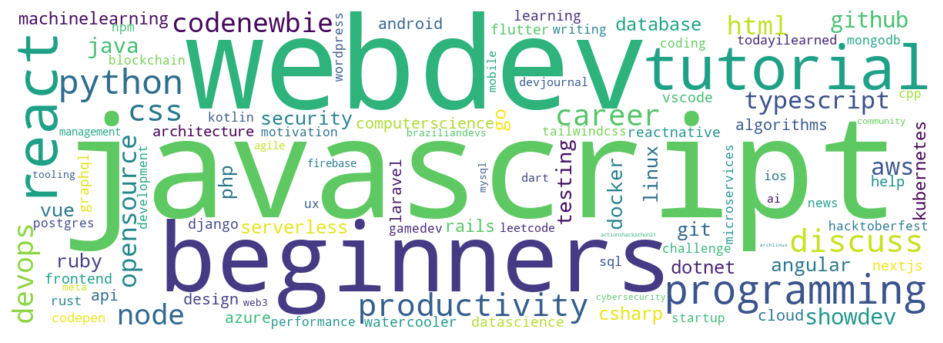

In [18]:
freqs = dict(tags.apply(lambda ts: (ts.tag, ts['count']), axis=1).values)
gen_tagcloud(lambda tc: tc.generate_from_frequencies(freqs))

The second is based on the top 10,000 articles dataframe.

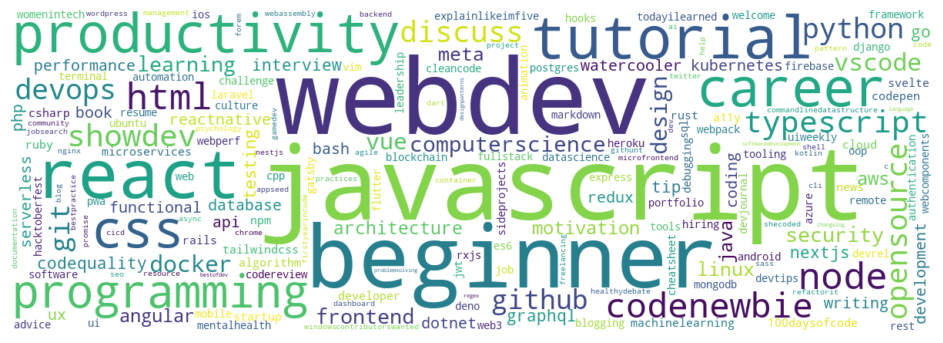

In [19]:
text = ' '.join(articles.tags.apply(lambda ts: ' '.join(ts)))
gen_tagcloud(lambda tc: tc.generate(text))

# Conclusion

From the analysis above, I conclude that articles on dev.to are mostly:

1. web development and web framework articles,
2. beginner articles for "newbies",
3. generic articles for productivity and career / tips and tricks,
4. generic articles on coding (programming, computer science)
4. technologies and tools that are used by all developers, but especially web devs (docker, git, github, vscode)

Other languages and frameworks that web developers do not use on a daily basis are fewer, or at least trigger fewer reactions and comments (kotlin, php, devops, datascience, machine learning, ...).

The data I have show that more than 50% of all interactions on dev.to happen on the tags `webdev`, `javascript`, and `beginners`. In other words, **if you are not a web developer and like to write about technical things, it will be hard to shine on dev.to**. This doesn't mean you shouldn't contribute though ! 